In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow_hub as hub

# import coremltools
print(tf.__version__)
print(tf.config.list_physical_devices())

2.9.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
configproto = tf.compat.v1.ConfigProto() 
configproto.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=configproto) 
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
training_data_dir = '../../datasets/nsfw_binary/'

img_shape = (224, 224, 3)
img_height = 224
img_width = 224
batch_size = 32
nb_epochs = 200

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
#     fill_mode='nearest',
    validation_split=0.2
)
train_generator = train_datagen.flow_from_directory(
    training_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    training_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

Found 30322 images belonging to 2 classes.
Found 7580 images belonging to 2 classes.


In [4]:
# tfjs model
model = tf.keras.models.Sequential([
     tf.keras.layers.Conv2D(16, (3,3), activation='relu',
                           input_shape=(224,224,3)),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Dropout(0.3),
     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Dropout(0.3),
     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Dropout(0.3),
     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Dropout(0.3),
     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Dropout(0.3),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(512, activation='relu'),
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dense(1, activation='sigmoid')
 ])

model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(0.01), metrics=['accuracy'])

In [5]:
# transfer learning
# mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
# inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

# feature_extractor_model = inception_v3

# feature_extractor_layer = hub.KerasLayer(
#     feature_extractor_model,
#     input_shape=(224, 224, 3),
#     trainable=False)

# model = tf.keras.Sequential([
#   feature_extractor_layer,
#   tf.keras.layers.Dropout(0.5),
#   tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dense(1, activation='softmax')
# ])

# model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(0.01), metrics=['accuracy'])

In [6]:
# load saved model
# model = tf.keras.models.load_model('../../saved_model/nsfw/hdf5/nsfw.hdf5')
# model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 32)        0

In [8]:
custom_early_stopping = EarlyStopping(
    patience=4, 
    verbose=1
)

In [9]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.000001,
    verbose=1,
    cooldown=1
)

In [10]:
filepath = '../../saved_model/nsfw/hdf5/nsfw.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=[custom_early_stopping, checkpoint, reduce_lr]
)

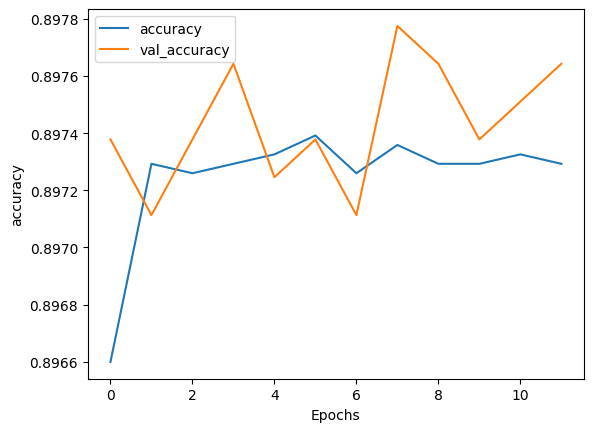

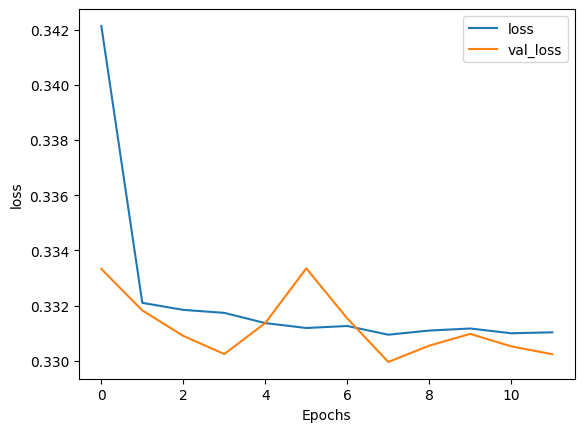

In [12]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [13]:
import numpy as np
from keras.preprocessing import image
from ipywidgets import FileUpload
from IPython.display import display

path = '../../datasets/nsfw/test/naked_woman.jpg'
img = tf.keras.utils.load_img(path, target_size=(224, 224))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)

image_tensor = np.vstack([x])
classes = model.predict(image_tensor)
print(classes)
print(classes[0])
# if classes[0]>0.5:
#     print("Image is a cat")
# else:
#     print("Image is a dog")

1/1 [==============================] - 0s 409ms/step
[[0.11832061]]
[0.11832061]


In [14]:
from PIL import Image

img = Image.open('../../datasets/nsfw/test/0MOxsHD.jpg')
img = img.resize((224, 224))
img = np.array(img)
img = np.expand_dims(img, 0)
classes = model.predict(img)
print(classes)

1/1 [==============================] - 0s 164ms/step
[[0.02017277]]


In [15]:
# Save model
export_dir = '../../saved_model/nsfw/v2/modeltfjs/'
#export_dir = '../../saved_model/nsfw/v2/modeltflite/'
model.save(export_dir)

INFO:tensorflow:Assets written to: ../../saved_model/nsfw/v2/modeltfjs/assets


INFO:tensorflow:Assets written to: ../../saved_model/nsfw/v2/modeltfjs/assets
